In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch

from vjf.model import VJF


In [2]:
# Setup precision and random seeds
torch.set_default_dtype(torch.double)  # using double precision
np.random.seed(0)
torch.manual_seed(0)

torch.Size([3184])


Text(0.5, 1.0, 'True state')

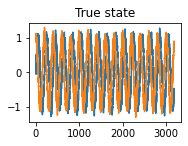

In [3]:
# Generate data
T = 100.  # length
dt = 1e-2 * math.pi  # size of time step
xdim = 2  # state dimensionality
ydim = 20  # obsetvation dimensionality
udim = 0  # size of control input

C = torch.randn(xdim, ydim)  # loading matrix
d = torch.randn(ydim)  # bias

t = torch.arange(0, T, step=dt)  # time point to be evaluated
x = torch.column_stack((torch.sin(t), torch.cos(t)))  # latent trajectory
x = x + torch.randn_like(x) * 0.1  # add some noise

# observation
y = x @ C + d
y = y + torch.randn_like(y) * 0.1  # add some noise

# Plot latent trajectory
fig = plt.figure()
ax = fig.add_subplot(221)
plt.plot(x.numpy())
plt.title('True state')

In [ ]:
# Setup and fit VJF 
n_rbf = 100  # number of radial basis functions for dynamical system
hidden_sizes = [20]  # size of hidden layers of recognition model
likelihood = 'gaussian'  # gaussian or poisson
# likelihood = 'poisson'  # gaussian or poisson

model = VJF.make_model(ydim, xdim, udim=udim, n_rbf=n_rbf, hidden_sizes=hidden_sizes, likelihood=likelihood)

q_seq = model.fit(y, max_iter=150)  # fit and return list of state posterior tuples (mean, log variance)

m = torch.stack([q.mean for q in q_seq])  # collect posterior mean
m = m.detach().numpy().squeeze()

Text(0.5, 1.0, 'Posterior mean')

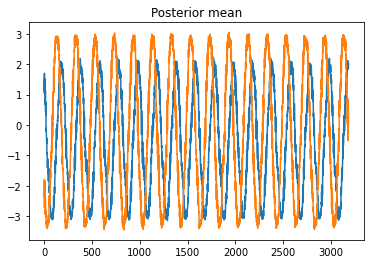

In [14]:
# draw the latent trajectory
ax = fig.add_subplot(222)
plt.plot(m)
plt.title('Posterior mean')

Text(0.5, 1.0, 'Velocity field')

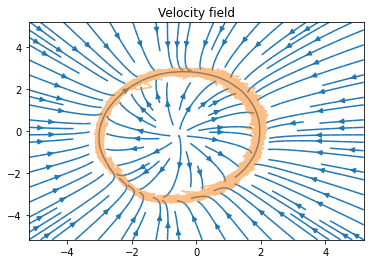

In [15]:
# Draw the inferred velocity field
def grid(n, lims):
    xedges = np.linspace(*lims, n)
    yedges = np.linspace(*lims, n)
    X, Y = np.meshgrid(xedges, yedges)
    grids = np.column_stack([X.reshape(-1), Y.reshape(-1)])
    return X, Y, grids

ax = fig.add_subplot(223)
r = np.mean(np.abs(m).max())  # determine the limits of plot

Xm, Ym, XYm = grid(51, [-1.5*r, 1.5*r])
Um, Vm = model.transition.velocity(torch.tensor(XYm)).detach().numpy().T  # get velocity
Um = np.reshape(Um, Xm.shape)
Vm = np.reshape(Vm, Ym.shape)
plt.streamplot(Xm, Ym, Um, Vm)
plt.plot(*m.T, color='C1', alpha=0.5, zorder=5)
plt.title('Velocity field')


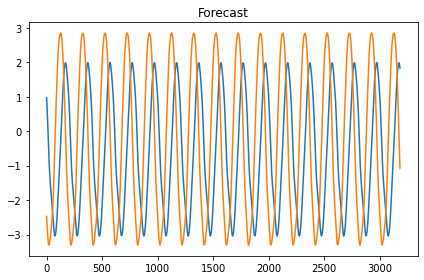

In [16]:
# Plot trajectory forecast
ax = fig.add_subplot(224)
x, y = model.forecast(x0=m[9, ...], n_step=int(100 / dt), noise=False)  # return predicted latent trajectory and observation
x = x.detach().numpy().squeeze()
plt.plot(x)
plt.title('Forecast')

plt.tight_layout()
plt.show()
plt.close()
